In [86]:
#import library
import warnings            
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn.ensemble import RandomForestClassifier

In [56]:
data = pd.read_csv('EurUsd.csv')

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28956 entries, 0 to 28955
Columns: 462 entries, time to 240_profitPips
dtypes: float64(20), int64(5), object(437)
memory usage: 102.1+ MB


In [58]:
data.shape

(28956, 462)

In [59]:
data = data.replace("?", np.nan)
data = data.dropna()
data.shape

(20360, 462)

In [60]:
data.drop(index = data[data['20_signal']=='NONE'].index, inplace = True)
data.shape

(17760, 462)

In [61]:
df = data.iloc[:, 5:430]
df_first = data.iloc[:,1:5]

In [62]:
df_result = data.filter(regex = '_signal')
df_result_numeric = data.filter(regex='_profitPips')

In [63]:
df_result_numeric.columns

Index(['20_profitPips', '30_profitPips', '40_profitPips', '50_profitPips',
       '60_profitPips', '70_profitPips', '80_profitPips', '90_profitPips',
       '100_profitPips', '120_profitPips', '140_profitPips', '160_profitPips',
       '180_profitPips', '200_profitPips', '220_profitPips', '240_profitPips'],
      dtype='object')

In [64]:
cat_column_names = ['ind_7','ind_11','ind_24','ind_38','ind_54','ind_57','ind_60','ind_63','ind_66','ind_69','ind_72','ind_75',
                    'ind_78','ind_81','ind_84','ind_87','ind_89','ind_91','ind_93','ind_95','ind_97','ind_99','ind_101',
                    'ind_103','ind_105','ind_107','ind_109', 'ind_111', 'ind_113', 'ind_115','ind_138','ind_141','ind_144',
                    'ind_157','ind_159','ind_161','ind_163','ind_165','ind_167','ind_169','ind_171','ind_173','ind_175',
                    'ind_177','ind_182','ind_184','ind_187','ind_190','ind_193','ind_196','ind_199','ind_202','ind_205',
                    'ind_208','ind_211','ind_213','ind_384','ind_386','ind_388','ind_390']

In [65]:
# categorical kolonların dummy var. oalrak değiştirdik
dms = pd.get_dummies(df[cat_column_names])
dms_none_cols = dms.filter(regex = '_NONE').columns
for i in dms_none_cols:
    dms.drop(i,axis=1,inplace=True)
dms_red_cols = dms.filter(regex = '_RED').columns
for i in dms_red_cols:
    dms.drop(i,axis=1,inplace=True)
#datadan categorical olan kolonları çıkarıyoruz ve type nı değiştiriyoruz
df_noncategoric = df.drop(cat_column_names,axis=1).astype("float64")
df_noncategoric = pd.DataFrame(df_noncategoric)
df_all = pd.concat([df_noncategoric, dms], axis=1)

#### PCA

#### Random Forest Regressor

In [66]:
# 1.3 - pca
def pca_fon(X, threshold):
    pca = PCA()
    X_pca = pca.fit_transform(scale(X))
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = X.index)
    return X_pcad

In [67]:
# 1.3 den gelen veriler.
X_raw2 = pd.concat([df_first,df_all], axis=1) 
X1_3 = pca_fon(X_raw2, 0.99)
X_raw2.shape, X1_3.shape

pca sonrası değişken sayısı:  191


((17760, 486), (17760, 191))

In [68]:
y = df_result_numeric['20_profitPips']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X1_3, y, test_size = 0.30, shuffle = False)

In [70]:
from sklearn.ensemble import RandomForestRegressor 
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 100) 
regressor.fit(X_train, y_train)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [71]:
y_pred = regressor.predict(X_test)
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 201.05819242786495


In [72]:
rf_params1 = {"max_depth":[5,7,8,10],
             "min_samples_split":[100,150,200,300],
             "max_features": [2,5,8], 
             "n_estimators": [10,500,1000]}
rf_model1 = RandomForestRegressor()
rf_cv_model1 = GridSearchCV(rf_model1,
                            rf_params1,
                            cv=10,
                            n_jobs=-1,
                            verbose=5)
rf_cv_model1.fit(X_train, y_train)
print("En iyi parametreler: "+str(rf_cv_model1.best_params_))

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 24.6min


En iyi parametreler: {'max_depth': 8, 'max_features': 2, 'min_samples_split': 300, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 35.2min finished


In [75]:
rf_tuned_1 = RandomForestRegressor(max_depth=8, max_features=2, min_samples_split=300, n_estimators=10)
rf_tuned_1.fit(X_train, y_train)
y_pred = rf_tuned_1.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 199.13449923394194


#### Desicion Tree Regressor

In [76]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
regressor = DecisionTreeRegressor()
cart1 = regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 404.7694480056216


In [77]:
cart_grid1 = {"max_depth":[50,100,200,300], "min_samples_split":[100,150,200,300]}
cart_cv1 = GridSearchCV(cart1, cart_grid1, cv=10, n_jobs =-1, verbose = 2)
cart_cv_model1 = cart_cv1.fit(X_train, y_train)
print('En iyi parametreler : ' + str(cart_cv_model1.best_params_))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   34.3s finished


En iyi parametreler : {'max_depth': 200, 'min_samples_split': 300}


In [78]:
cart_1 = DecisionTreeRegressor(max_depth = 200, min_samples_split=300)
cart_tuned_1 = cart_1.fit(X_train, y_train)
y_pred = cart_tuned_1.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 227.69564238318796


#### Keras Regressor

Using TensorFlow backend.


Train on 12432 samples, validate on 5328 samples
Epoch 1/100
12432/12432 [==============================] - 1s 54us/step - loss: 219.2685 - val_loss: 200.7797
Epoch 2/100
12432/12432 [==============================] - 0s 18us/step - loss: 211.2165 - val_loss: 209.8075
Epoch 3/100
12432/12432 [==============================] - 0s 18us/step - loss: 193.7899 - val_loss: 220.2659
Epoch 4/100
12432/12432 [==============================] - 0s 18us/step - loss: 175.5071 - val_loss: 237.4046
Epoch 5/100
12432/12432 [==============================] - 0s 18us/step - loss: 157.5363 - val_loss: 251.4579
Epoch 6/100
12432/12432 [==============================] - 0s 18us/step - loss: 140.1620 - val_loss: 260.5351
Epoch 7/100
12432/12432 [==============================] - 0s 18us/step - loss: 126.6175 - val_loss: 262.9397
Epoch 8/100
12432/12432 [==============================] - 0s 18us/step - loss: 114.8483 - val_loss: 279.2992
Epoch 9/100
12432/12432 [==============================] - 0s 18us/step

Epoch 75/100
12432/12432 [==============================] - 0s 20us/step - loss: 12.2842 - val_loss: 350.5254
Epoch 76/100
12432/12432 [==============================] - 0s 19us/step - loss: 13.1186 - val_loss: 342.1678
Epoch 77/100
12432/12432 [==============================] - 0s 19us/step - loss: 16.7686 - val_loss: 354.1047
Epoch 78/100
12432/12432 [==============================] - 0s 19us/step - loss: 27.4093 - val_loss: 346.4764
Epoch 79/100
12432/12432 [==============================] - 0s 20us/step - loss: 31.4778 - val_loss: 334.1848
Epoch 80/100
12432/12432 [==============================] - 0s 19us/step - loss: 28.1271 - val_loss: 336.5737
Epoch 81/100
12432/12432 [==============================] - 0s 21us/step - loss: 22.9432 - val_loss: 343.6703
Epoch 82/100
12432/12432 [==============================] - 0s 22us/step - loss: 19.5229 - val_loss: 346.4088
Epoch 83/100
12432/12432 [==============================] - 0s 22us/step - loss: 16.9547 - val_loss: 348.7715
Epoch 84/1

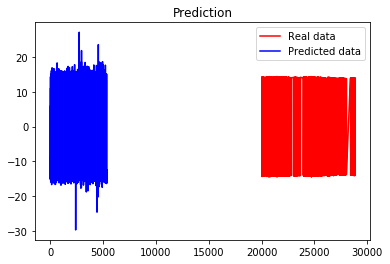

In [79]:
# Feature Scaling
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim =X_train.shape[1]))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))


# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))


# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))


# Adding the output layer

model.add(Dense(units = 1))


#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history =  model.fit(X_train, y_train, batch_size = 150, epochs = 100, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [80]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 351.0123265904586


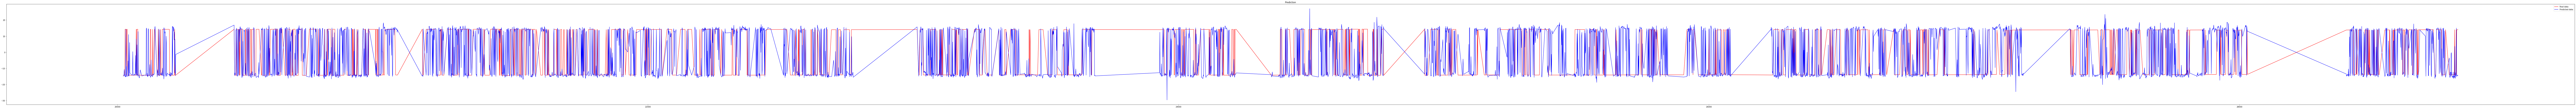

In [81]:
y_pred = pd.DataFrame(y_pred)
y_pred = pd.Series(y_pred[0])
plt.figure(figsize=(250,10))
y_pred.index = y_test.index
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

dict_keys(['val_loss', 'loss'])


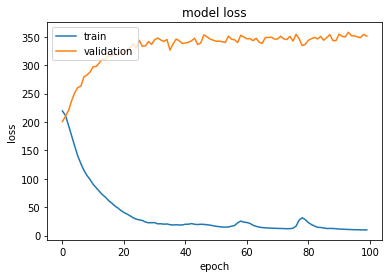

In [82]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Random Forest İmportant X'ler

#### Random Forest

In [83]:
# 1.2 RandomForest
# bütün değişkenlerle yapılan random forest sonucu importance değeri verilen parametreden büyük olan değişkenleri döner
def rand_forest(X, y, imp_value):
    rf_model = RandomForestClassifier().fit(X, y)
    Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, index = X.columns)
    imp_values = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)
    imp_values = imp_values[imp_values['Importance']>imp_value]
    col_names = imp_values.index   
    return X[col_names]

In [84]:
y = df_result['20_signal']
y_numeric = df_result_numeric['20_profitPips']

In [87]:
X_raw = pd.concat([df_first,df_all], axis=1) 
X1_2 = rand_forest(X_raw, y, 0.1)    
X1_2.shape

(17760, 259)

In [88]:
X_train2, X_test2, y_train, y_test = train_test_split(X1_2, y_numeric, test_size = 0.30, shuffle = False)

In [89]:
from sklearn.ensemble import RandomForestRegressor 
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 100) 
regressor.fit(X_train2, y_train)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [91]:
y_pred = regressor.predict(X_test2)
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 195.9507177249394


In [92]:
rf_params2 = {"max_depth":[5,7,8,10],
              "min_samples_split":[100,150,200,300],
              "max_features": [2,5,8], 
              "n_estimators": [10,500,1000]}
rf_model2 = RandomForestRegressor()
rf_cv_model2 = GridSearchCV(rf_model2,
                            rf_params2,
                            cv=10,
                            n_jobs=-1,
                            verbose=5)
rf_cv_model2.fit(X_train2, y_train)
print("En iyi parametreler: "+str(rf_cv_model2.best_params_))

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 17.5min


En iyi parametreler: {'max_depth': 5, 'max_features': 8, 'min_samples_split': 100, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 24.6min finished


In [93]:
rf_tuned_2 = RandomForestRegressor(max_depth=5, max_features=8, min_samples_split=100, n_estimators=10)
rf_tuned_2.fit(X_train2, y_train)
y_pred = rf_tuned_2.predict(X_test2)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 197.3727749838709


#### Desicion Tree Regressor

In [94]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
regressor = DecisionTreeRegressor()
cart2 = regressor.fit(X_train2,y_train)
y_pred = cart2.predict(X_test2)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 405.9743787518557


In [95]:
cart_grid2 = {"max_depth":[50,100,200,300], "min_samples_split":[100,150,200,300]}
cart_cv2 = GridSearchCV(cart2, cart_grid2, cv=10, n_jobs =-1, verbose = 2)
cart_cv_model2 = cart_cv2.fit(X_train2, y_train)
print('En iyi parametreler : ' + str(cart_cv_model2.best_params_))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   36.0s finished


En iyi parametreler : {'max_depth': 200, 'min_samples_split': 300}


In [96]:
cart_2 = DecisionTreeRegressor(max_depth = 200, min_samples_split=300)
cart_tuned_2 = cart_2.fit(X_train2, y_train)
y_pred = cart_tuned_2.predict(X_test2)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 234.5045175964308


#### Keras Regressor

Train on 12432 samples, validate on 5328 samples
Epoch 1/100
12432/12432 [==============================] - 1s 50us/step - loss: 218.5842 - val_loss: 197.7780
Epoch 2/100
12432/12432 [==============================] - 0s 20us/step - loss: 213.8581 - val_loss: 195.1952
Epoch 3/100
12432/12432 [==============================] - 0s 19us/step - loss: 202.6673 - val_loss: 199.7684
Epoch 4/100
12432/12432 [==============================] - 0s 19us/step - loss: 187.6890 - val_loss: 214.2803
Epoch 5/100
12432/12432 [==============================] - 0s 19us/step - loss: 173.5395 - val_loss: 221.3014
Epoch 6/100
12432/12432 [==============================] - 0s 19us/step - loss: 161.5209 - val_loss: 236.9513
Epoch 7/100
12432/12432 [==============================] - 0s 19us/step - loss: 152.1474 - val_loss: 247.8935
Epoch 8/100
12432/12432 [==============================] - 0s 20us/step - loss: 144.4224 - val_loss: 254.2477
Epoch 9/100
12432/12432 [==============================] - 0s 19us/step

Epoch 75/100
12432/12432 [==============================] - 0s 19us/step - loss: 27.9490 - val_loss: 358.1439
Epoch 76/100
12432/12432 [==============================] - 0s 19us/step - loss: 30.1585 - val_loss: 359.1022
Epoch 77/100
12432/12432 [==============================] - 0s 19us/step - loss: 29.3957 - val_loss: 344.7601
Epoch 78/100
12432/12432 [==============================] - 0s 19us/step - loss: 29.8368 - val_loss: 358.1638
Epoch 79/100
12432/12432 [==============================] - 0s 20us/step - loss: 28.7649 - val_loss: 348.2682
Epoch 80/100
12432/12432 [==============================] - 0s 20us/step - loss: 28.4293 - val_loss: 358.6760
Epoch 81/100
12432/12432 [==============================] - ETA: 0s - loss: 27.05 - 0s 19us/step - loss: 28.9601 - val_loss: 357.0090
Epoch 82/100
12432/12432 [==============================] - 0s 20us/step - loss: 27.3992 - val_loss: 356.0046
Epoch 83/100
12432/12432 [==============================] - 0s 20us/step - loss: 26.9794 - val_l

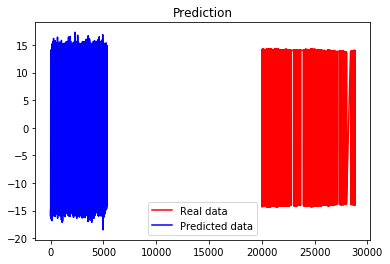

In [98]:
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_2 = sc.fit_transform(X_train2)
X_test_2 = sc.transform(X_test2)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim =X_train_2.shape[1]))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history = model.fit(X_train_2, y_train, batch_size = 150, epochs = 100, validation_data=(X_test_2, y_test))

y_pred = model.predict(X_test_2)

plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [99]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 366.9247766287466


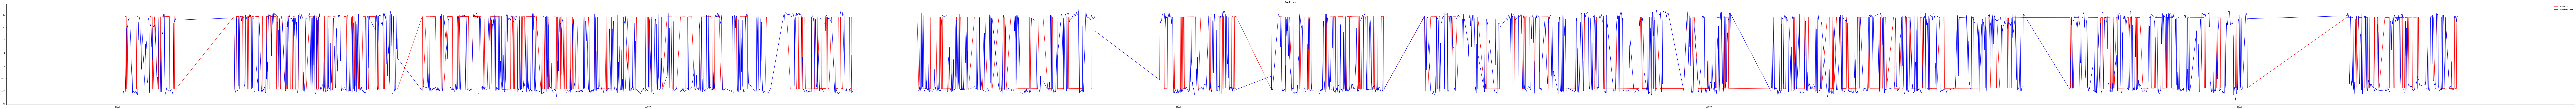

In [100]:
y_pred = pd.DataFrame(y_pred)
y_pred = pd.Series(y_pred[0])
plt.figure(figsize=(250,10))
y_pred.index = y_test.index
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

dict_keys(['val_loss', 'loss'])


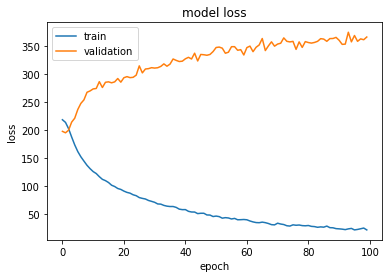

In [101]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Non Corelated X'ler

#### Random Forest Regressor

In [102]:
# 1.1 - dropping correlaritions
def corr_df(df, corr_val):
    corr_matrix = df_noncategoric.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_high = [column for column in upper.columns if any(upper[column] > corr_val)]
    df.drop(to_high, axis = 1, inplace = True)
    return df

In [104]:
df_noncorr = corr_df(df_noncategoric, 0.50)

In [105]:
X1_1 = pd.concat([df_first, df_noncorr, dms], axis=1)
X1_1.shape  #non correlatedları çıkarınca elimizde 204 kolon kaldı

(17760, 204)

In [106]:
y = df_result_numeric['20_profitPips']

In [108]:
X_train3, X_test3, y_train, y_test = train_test_split(X1_1, y, test_size = 0.30, shuffle = False)

In [109]:
from sklearn.ensemble import RandomForestRegressor 
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 100) 
regressor.fit(X_train3, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [110]:
y_pred = regressor.predict(X_test3)
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 212.4594361591609


In [111]:
rf_params3 = {"max_depth":[5,7,8,10],
              "min_samples_split":[100,150,200,300],
              "max_features": [2,5,8], 
              "n_estimators": [10,500,1000]}
rf_model3 = RandomForestRegressor()
rf_cv_model3 = GridSearchCV(rf_model3,
                            rf_params3,
                            cv=10,
                            n_jobs=-1,
                            verbose=5)
rf_cv_model3.fit(X_train3, y_train)
print("En iyi parametreler: "+str(rf_cv_model3.best_params_))

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.8min finished


En iyi parametreler: {'max_depth': 5, 'max_features': 5, 'min_samples_split': 300, 'n_estimators': 500}


In [112]:
rf_tuned_3 = RandomForestRegressor(max_depth=5, max_features=5, min_samples_split=300, n_estimators=500)
rf_tuned_3.fit(X_train3, y_train)
y_pred = rf_tuned_3.predict(X_test3)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 198.85713445656452


#### Desicion Tree Regressor

In [113]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
regressor = DecisionTreeRegressor()
cart3 = regressor.fit(X_train3,y_train)
y_pred = cart3.predict(X_test3)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 407.56604762308314


In [114]:
cart_grid3 = {"max_depth":[50,100,200,300], "min_samples_split":[100,150,200,300]}
cart_cv3 = GridSearchCV(cart3, cart_grid2, cv=10, n_jobs =-1, verbose = 2)
cart_cv_model3 = cart_cv3.fit(X_train3, y_train)
print('En iyi parametreler : ' + str(cart_cv_model3.best_params_))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.4s finished


En iyi parametreler : {'max_depth': 100, 'min_samples_split': 300}


In [115]:
cart_3 = DecisionTreeRegressor(max_depth = 100, min_samples_split=300)
cart_tuned_3 = cart_3.fit(X_train3, y_train)
y_pred = cart_tuned_3.predict(X_test3)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 260.43558338698836


#### Keras Regressor

Train on 12432 samples, validate on 5328 samples
Epoch 1/100
12432/12432 [==============================] - 1s 49us/step - loss: 218.9837 - val_loss: 199.3427
Epoch 2/100
12432/12432 [==============================] - 0s 19us/step - loss: 215.2752 - val_loss: 198.8950
Epoch 3/100
12432/12432 [==============================] - 0s 18us/step - loss: 207.4838 - val_loss: 206.7815
Epoch 4/100
12432/12432 [==============================] - 0s 20us/step - loss: 197.4025 - val_loss: 212.7990
Epoch 5/100
12432/12432 [==============================] - 0s 21us/step - loss: 185.5802 - val_loss: 225.9954
Epoch 6/100
12432/12432 [==============================] - 0s 21us/step - loss: 175.3405 - val_loss: 229.0768
Epoch 7/100
12432/12432 [==============================] - 0s 21us/step - loss: 164.6052 - val_loss: 239.2729
Epoch 8/100
12432/12432 [==============================] - 0s 21us/step - loss: 155.9352 - val_loss: 242.7726
Epoch 9/100
12432/12432 [==============================] - 0s 19us/step

Epoch 75/100
12432/12432 [==============================] - 0s 20us/step - loss: 37.1410 - val_loss: 347.6704
Epoch 76/100
12432/12432 [==============================] - 0s 20us/step - loss: 36.6273 - val_loss: 347.3069
Epoch 77/100
12432/12432 [==============================] - 0s 20us/step - loss: 34.2253 - val_loss: 344.5496
Epoch 78/100
12432/12432 [==============================] - 0s 19us/step - loss: 33.7028 - val_loss: 339.6099
Epoch 79/100
12432/12432 [==============================] - 0s 19us/step - loss: 33.2478 - val_loss: 341.7010
Epoch 80/100
12432/12432 [==============================] - 0s 19us/step - loss: 35.0178 - val_loss: 332.2417
Epoch 81/100
12432/12432 [==============================] - 0s 19us/step - loss: 33.8294 - val_loss: 346.3501
Epoch 82/100
12432/12432 [==============================] - 0s 19us/step - loss: 32.6632 - val_loss: 344.6086
Epoch 83/100
12432/12432 [==============================] - 0s 19us/step - loss: 32.9586 - val_loss: 342.2698
Epoch 84/1

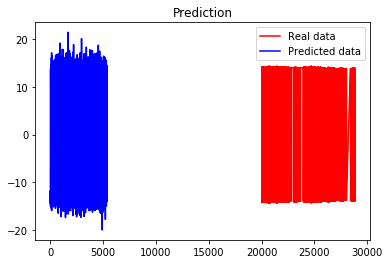

In [116]:
# Feature Scaling

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_3 = sc.fit_transform(X_train3)
X_test_3 = sc.transform(X_test3)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim =204))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))


# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))


# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history = model.fit(X_train_3, y_train, batch_size = 150, epochs = 100, validation_data=(X_test_3, y_test))

y_pred = model.predict(X_test_3)

plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [117]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 351.47410811614367


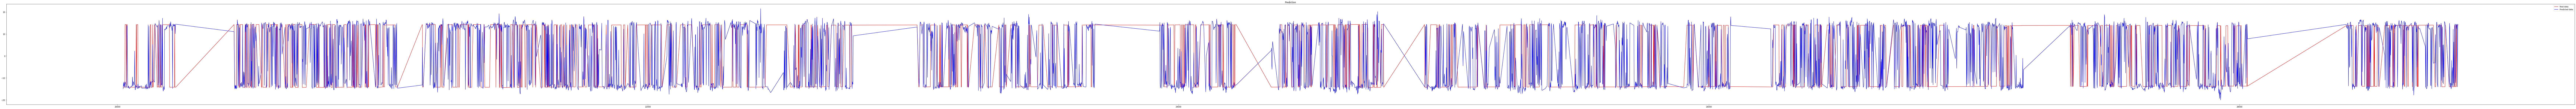

In [118]:
y_pred = pd.DataFrame(y_pred)
y_pred = pd.Series(y_pred[0])
plt.figure(figsize=(250,10))
y_pred.index = y_test.index
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

dict_keys(['val_loss', 'loss'])


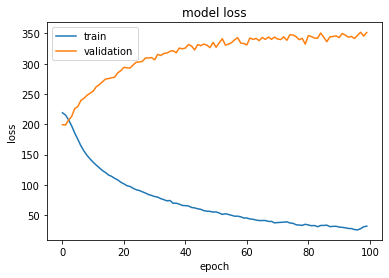

In [119]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()